<a href="https://colab.research.google.com/github/taemin-hwang/study-space/blob/master/triangulation_DLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## READ CAMERA PARAMETER

In [3]:
import os.path
import numpy as np
import cv2

class FileStorage(object):
    def __init__(self, filename, isWrite=False):
        version = cv2.__version__
        self.major_version = int(version.split('.')[0])
        self.second_version = int(version.split('.')[1])

        if isWrite:
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            self.fs = cv2.FileStorage(filename, cv2.FILE_STORAGE_WRITE)
        else:
            self.fs = cv2.FileStorage(filename, cv2.FILE_STORAGE_READ)

    def __del__(self):
        cv2.FileStorage.release(self.fs)

    def write(self, key, value, dt='mat'):
        if dt == 'mat':
            cv2.FileStorage.write(self.fs, key, value)
        elif dt == 'list':
            if self.major_version == 4: # 4.4
                self.fs.startWriteStruct(key, cv2.FileNode_SEQ)
                for elem in value:
                    self.fs.write('', elem)
                self.fs.endWriteStruct()
            else: # 3.4
                self.fs.write(key, '[')
                for elem in value:
                    self.fs.write('none', elem)
                self.fs.write('none', ']')

    def read(self, key, dt='mat'):
        if dt == 'mat':
            output = self.fs.getNode(key).mat()
        elif dt == 'list':
            results = []
            n = self.fs.getNode(key)
            for i in range(n.size()):
                val = n.at(i).string()
                if val == '':
                    val = str(int(n.at(i).real()))
                if val != 'none':
                    results.append(val)
            output = results
        else:
            raise NotImplementedError
        return output

    def close(self):
        self.__del__(self)

def read_camera(intri_path, extri_path):
  assert os.path.exists(intri_path), intri_path
  assert os.path.exists(extri_path), extri_path

  intri = FileStorage(intri_path)
  extri = FileStorage(extri_path)
  cams, P = {}, {}
  cam_names = intri.read('names', dt='list')
  for cam in cam_names:
      cams[cam] = {}
      cams[cam]['K'] = intri.read('K_{}'.format( cam))
      cams[cam]['invK'] = np.linalg.inv(cams[cam]['K'])
      Rvec = extri.read('R_{}'.format(cam))
      Tvec = extri.read('T_{}'.format(cam))
      R = cv2.Rodrigues(Rvec)[0]
      RT = np.hstack((R, Tvec))

      cams[cam]['RT'] = RT
      cams[cam]['R'] = R
      cams[cam]['T'] = Tvec
      P[cam] = cams[cam]['K'] @ cams[cam]['RT']
      cams[cam]['P'] = P[cam]

      cams[cam]['dist'] = intri.read('dist_{}'.format(cam))
  cams['basenames'] = cam_names
  return cams

def print_camera_parameter(cams):
  for i in range(1, 5):
    print('CAM # : ', i, ' ============================================================ ')
    print('   K  : ', cams[str(i)]['K'])
    print('   RT : ', cams[str(i)]['RT'])
    print('   P : ', cams[str(i)]['P'])

dir = '/content/drive/MyDrive/Colab Notebooks/workspace/triangulation/'

intri_path = dir+'intri.yml'
extri_path = dir+'extri.yml'

cams = read_camera(intri_path, extri_path)
print_camera_parameter(cams)

CAM # :  1  ============================================================ 
   K  :  [[530.57   0.   646.48]
 [  0.   530.3  359.54]
 [  0.     0.     1.  ]]
   RT :  [[ 0.5706371   0.82116109  0.00823235 -0.47410973]
 [-0.31747649  0.21135168  0.92441287  0.47519205]
 [ 0.75735195 -0.53011785  0.38130445  2.64992997]]
   P :  [[ 7.92375816e+02  9.29728486e+01  2.50873535e+02  1.46157833e+03]
 [ 1.03940540e+02 -7.85187766e+01  6.27310344e+02  1.20475016e+03]
 [ 7.57351953e-01 -5.30117852e-01  3.81304447e-01  2.64992997e+00]]
CAM # :  2  ============================================================ 
   K  :  [[530.57   0.   646.48]
 [  0.   530.3  359.54]
 [  0.     0.     1.  ]]
   RT :  [[-0.65612676  0.75453876 -0.01299744 -0.36944838]
 [-0.22458879 -0.17879576  0.9579102   0.87813287]
 [ 0.72045649  0.6314296   0.28677363  2.15159146]]
   P :  [[1.17639535e+02 8.08542235e+02 1.78497364e+02 1.19494262e+03]
 [1.39933493e+02 1.32208804e+02 6.11086370e+02 1.23925706e+03]
 [7.20456488e-01 6

## READ SKELETON

In [4]:
import json

skeletons_2d = {}
for cam_id in range(1, 5):
  filename = 'cam' + str(cam_id) + '.json'
  with open(dir + 'annots/' + filename, "r") as json_file:
    json_data = json.load(json_file)
    keypoints = np.array(json_data['annots'][0]['keypoints'])
    skeletons_2d[str(cam_id)] = keypoints

## READ IMAGE

(720, 1279, 3)


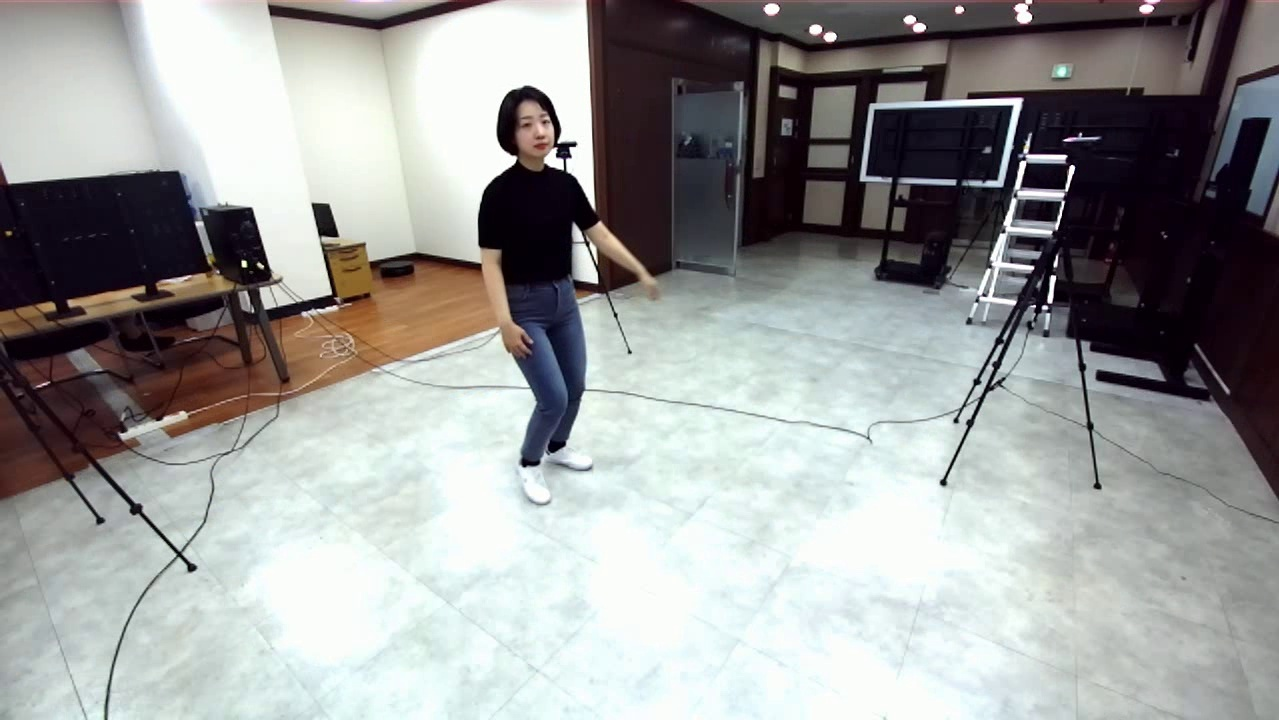

(720, 1279, 3)


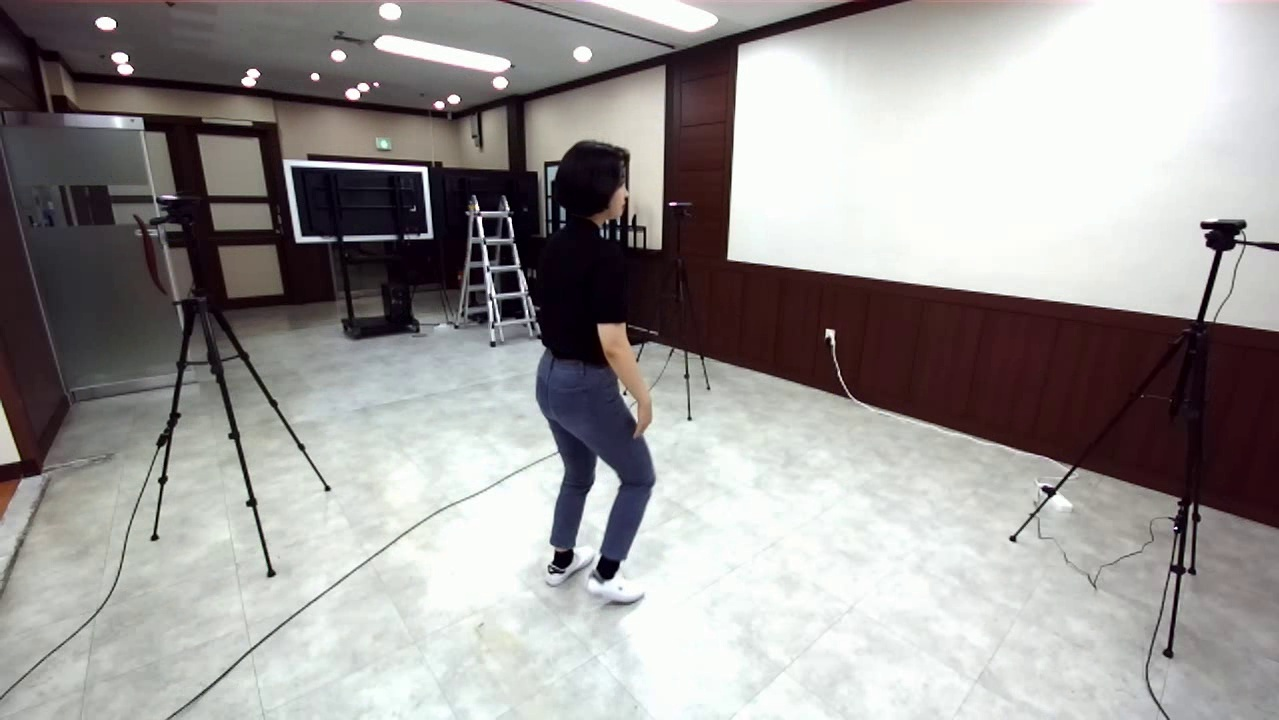

(720, 1279, 3)


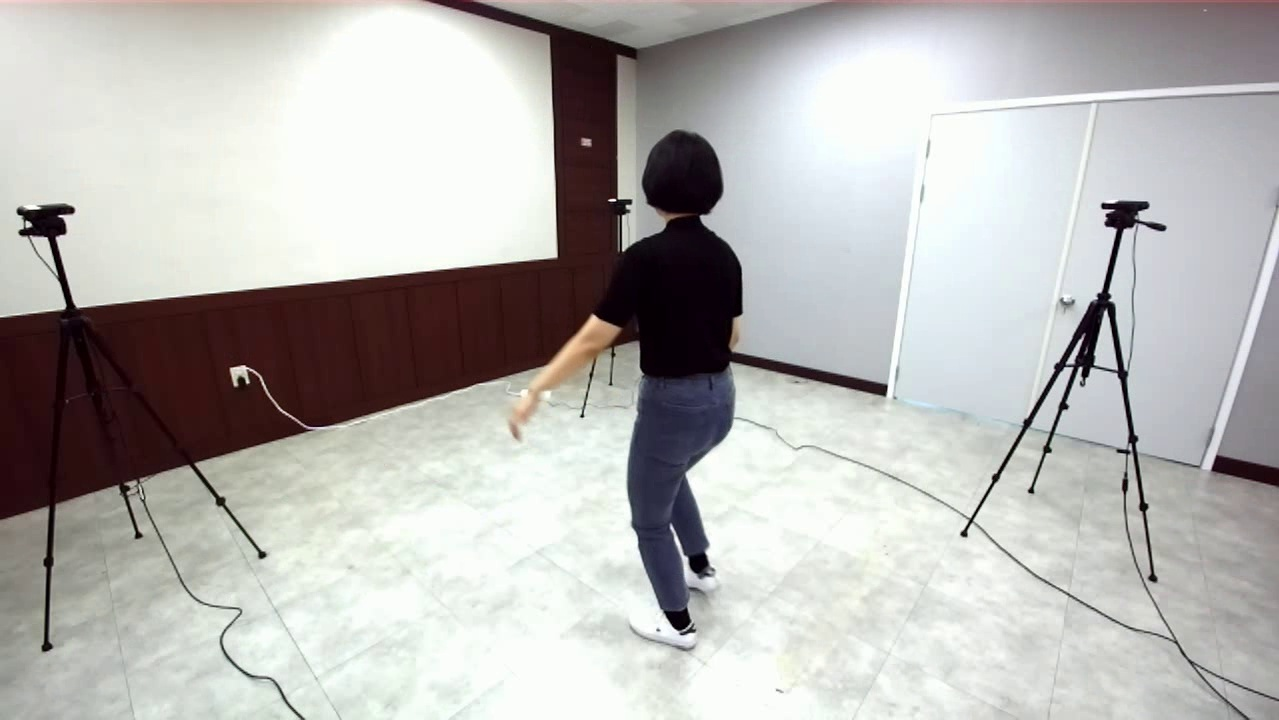

(720, 1279, 3)


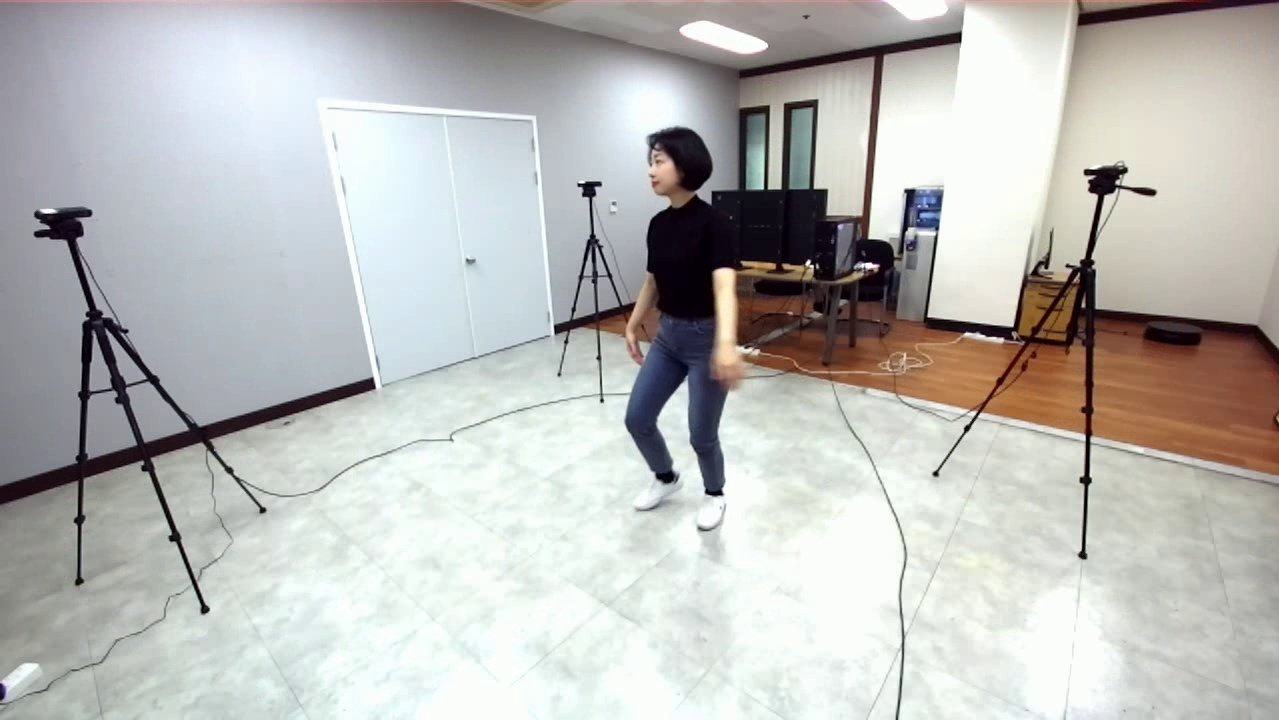

In [9]:
import cv2
from google.colab.patches import cv2_imshow

images = {}
for cam_id in range(1, 5):
  filename = 'cam' + str(cam_id) + '.jpg'
  img = cv2.imread(dir + 'images/' + filename, cv2.IMREAD_COLOR) 
  images[str(cam_id)] = img
  print(img.shape)
  cv2_imshow(img)

## IMAGE COMPOSITION

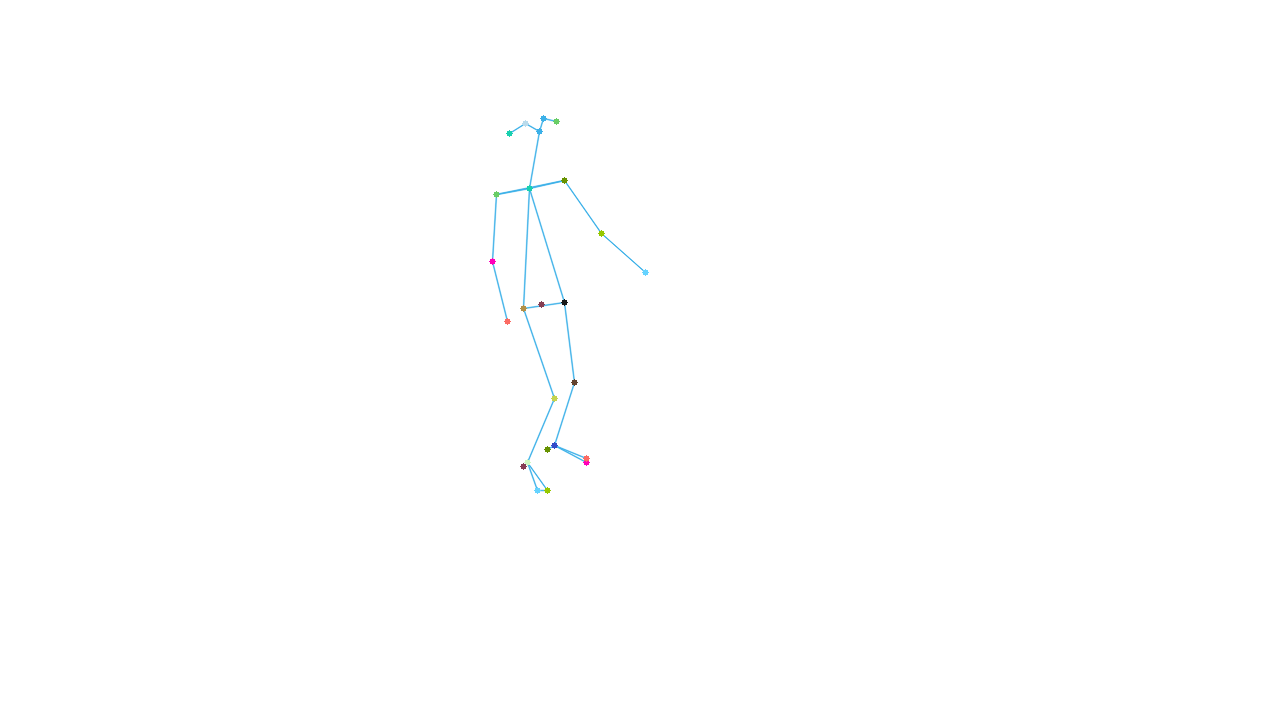

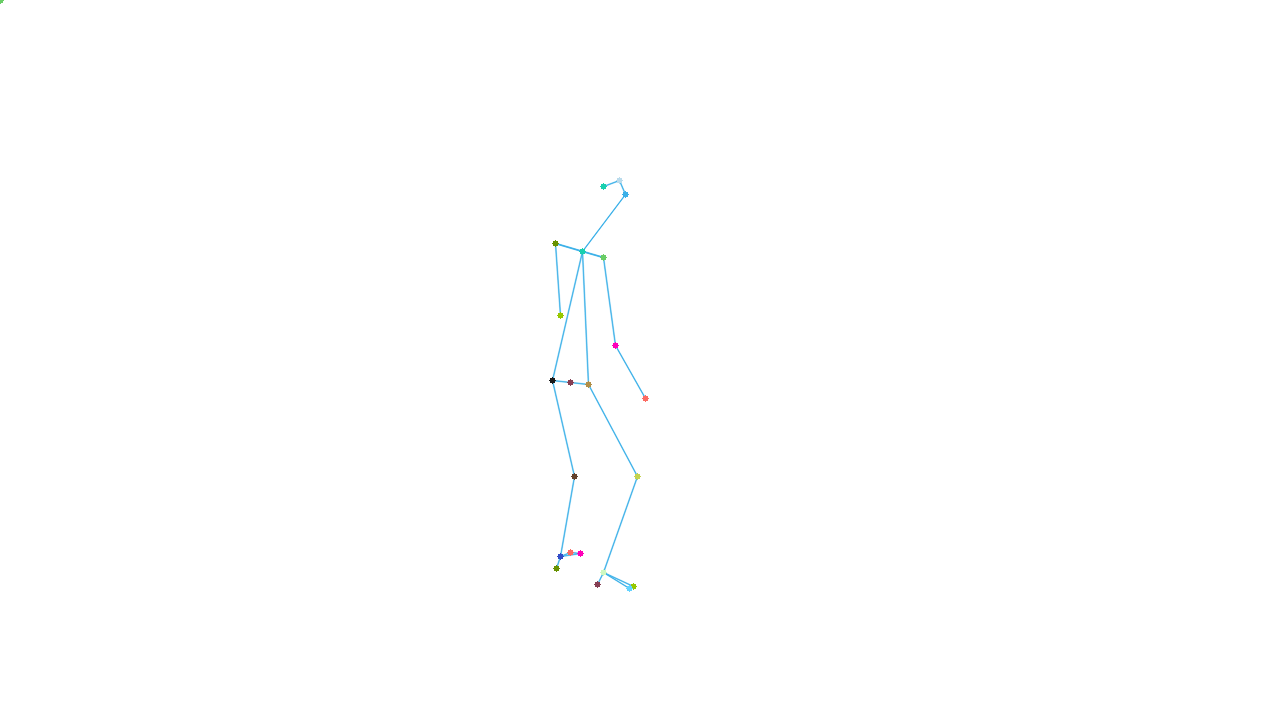

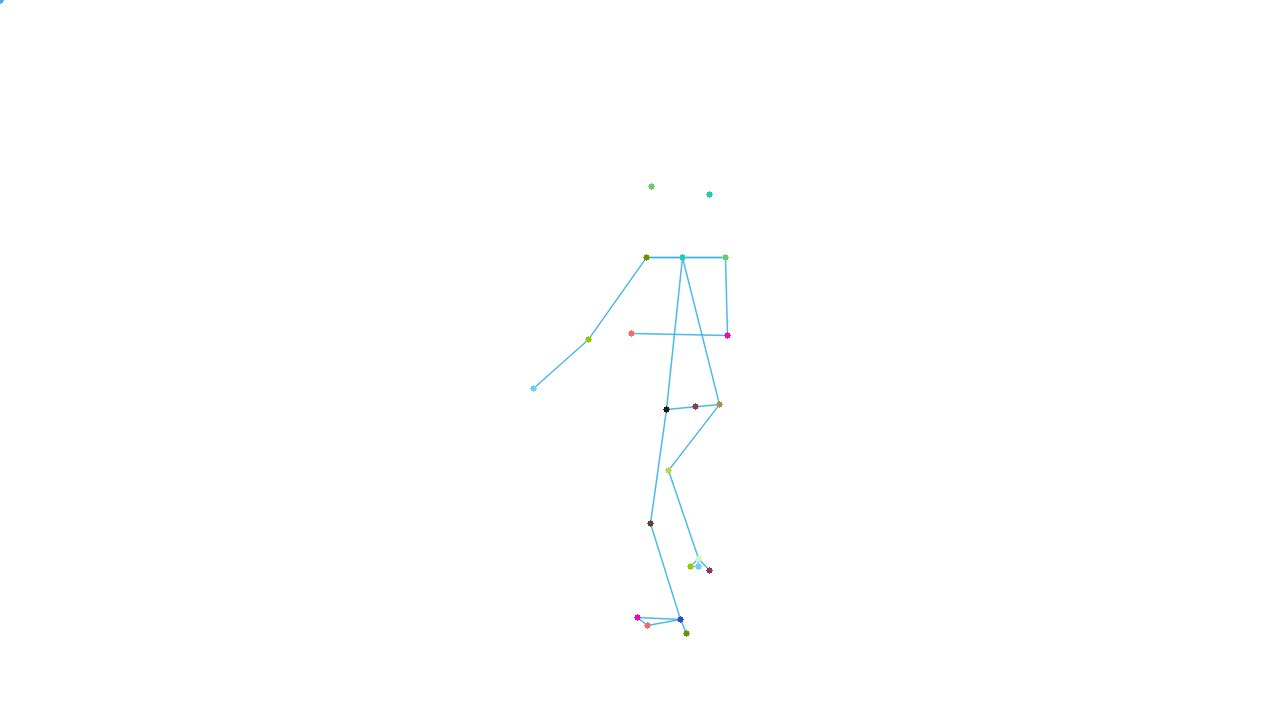

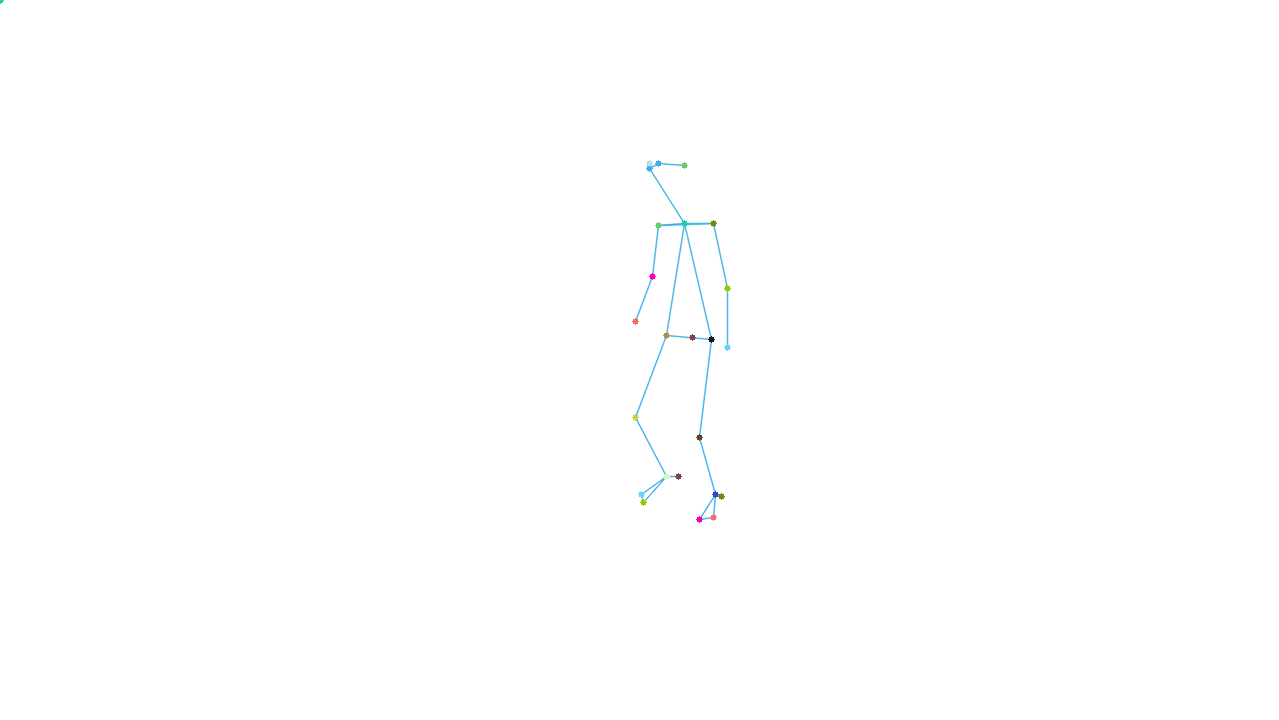

In [11]:
from enum import Enum

class BODY_PARTS_POSE_25(Enum):
    NOSE = 0
    NECK = 1
    RIGHT_SHOULDER = 2
    RIGHT_ELBOW = 3
    RIGHT_WRIST = 4
    LEFT_SHOULDER = 5
    LEFT_ELBOW = 6
    LEFT_WRIST = 7
    MID_HIP = 8
    RIGHT_HIP = 9
    RIGHT_KNEE = 10
    RIGHT_ANKLE = 11
    LEFT_HIP = 12
    LEFT_KNEE = 13
    LEFT_ANKLE = 14
    RIGHT_EYE = 15
    LEFT_EYE = 16
    RIGHT_EAR = 17
    LEFT_EAR = 18
    LEFT_FOOT = 19
    LEFT_TOE = 20
    LEFT_HEEL = 21
    RIGHT_FOOT = 22
    RIGHT_TOE = 23
    RIGHT_HEEL = 24
    LAST = 25

BODY_BONES_POSE_25 = [ (BODY_PARTS_POSE_25.NOSE, BODY_PARTS_POSE_25.NECK),
                (BODY_PARTS_POSE_25.NECK, BODY_PARTS_POSE_25.RIGHT_SHOULDER),
                (BODY_PARTS_POSE_25.RIGHT_SHOULDER, BODY_PARTS_POSE_25.RIGHT_ELBOW),
                (BODY_PARTS_POSE_25.RIGHT_ELBOW, BODY_PARTS_POSE_25.RIGHT_WRIST),
                (BODY_PARTS_POSE_25.NECK, BODY_PARTS_POSE_25.LEFT_SHOULDER),
                (BODY_PARTS_POSE_25.NECK, BODY_PARTS_POSE_25.RIGHT_HIP),
                (BODY_PARTS_POSE_25.NECK, BODY_PARTS_POSE_25.LEFT_HIP),
                (BODY_PARTS_POSE_25.LEFT_SHOULDER, BODY_PARTS_POSE_25.LEFT_ELBOW),
                (BODY_PARTS_POSE_25.LEFT_ELBOW, BODY_PARTS_POSE_25.LEFT_WRIST),
                (BODY_PARTS_POSE_25.RIGHT_HIP, BODY_PARTS_POSE_25.RIGHT_KNEE),
                (BODY_PARTS_POSE_25.RIGHT_KNEE, BODY_PARTS_POSE_25.RIGHT_ANKLE),
                (BODY_PARTS_POSE_25.LEFT_HIP, BODY_PARTS_POSE_25.LEFT_KNEE),
                (BODY_PARTS_POSE_25.LEFT_KNEE, BODY_PARTS_POSE_25.LEFT_ANKLE),
                (BODY_PARTS_POSE_25.RIGHT_SHOULDER, BODY_PARTS_POSE_25.LEFT_SHOULDER),
                (BODY_PARTS_POSE_25.RIGHT_HIP, BODY_PARTS_POSE_25.LEFT_HIP),
                (BODY_PARTS_POSE_25.NOSE, BODY_PARTS_POSE_25.RIGHT_EYE),
                (BODY_PARTS_POSE_25.RIGHT_EYE, BODY_PARTS_POSE_25.RIGHT_EAR),
                (BODY_PARTS_POSE_25.NOSE, BODY_PARTS_POSE_25.LEFT_EYE),
                (BODY_PARTS_POSE_25.LEFT_EYE, BODY_PARTS_POSE_25.LEFT_EAR),
                (BODY_PARTS_POSE_25.LEFT_ANKLE, BODY_PARTS_POSE_25.LEFT_HEEL),
                (BODY_PARTS_POSE_25.RIGHT_ANKLE, BODY_PARTS_POSE_25.RIGHT_HEEL),
                (BODY_PARTS_POSE_25.LEFT_ANKLE, BODY_PARTS_POSE_25.LEFT_FOOT),
                (BODY_PARTS_POSE_25.RIGHT_ANKLE, BODY_PARTS_POSE_25.RIGHT_FOOT),
                (BODY_PARTS_POSE_25.RIGHT_FOOT, BODY_PARTS_POSE_25.RIGHT_TOE), #NOTE
                (BODY_PARTS_POSE_25.LEFT_FOOT, BODY_PARTS_POSE_25.LEFT_TOE), #NOTE
                (BODY_PARTS_POSE_25.RIGHT_ANKLE, BODY_PARTS_POSE_25.RIGHT_TOE), #NOTE
                (BODY_PARTS_POSE_25.LEFT_ANKLE, BODY_PARTS_POSE_25.LEFT_TOE) #NOTE
                ]

ID_COLORS = [(232, 176, 59)
            ,(175, 208, 25)
            ,(102, 205, 105)
            ,(185, 0, 255)
            ,(99, 107, 252)
            ,(1, 146, 103)
            ,(0, 200, 151)
            ,(255, 211, 101)
            ,(83, 62, 133)
            ,(72, 143, 177)
            ,(79, 211, 196)
            ,(193, 248, 207)
            ,(25, 25, 25)
            ,(45, 66, 99)
            ,(200, 75, 49)
            ,(236, 219, 186)
            ]

def generate_color_id_u(idx):
    arr = []
    if(idx < 0):
        arr = [236,184,36,255]
    else:
        color_idx = idx % 16
        arr = [ID_COLORS[color_idx][0], ID_COLORS[color_idx][1], ID_COLORS[color_idx][2], 255]
    return arr

def draw_skeleton(image, keypoints):
  # Draw skeleton bones
  for part in BODY_BONES_POSE_25:
    line_color = generate_color_id_u(0)
    kp_a = keypoints[part[0].value]
    kp_b = keypoints[part[1].value]
    # Check that the keypoints are inside the image
    if(kp_a[0] < image.shape[1] and kp_a[1] < image.shape[0]
    and kp_b[0] < image.shape[1] and kp_b[1] < image.shape[0]
    and kp_a[0] > 0 and kp_a[1] > 0 and kp_b[0] > 0 and kp_b[1] > 0 ):
      cv2.line(image, (int(kp_a[0]), int(kp_a[1])), (int(kp_b[0]), int(kp_b[1])), line_color, 1, cv2.LINE_AA)

  #  for kp in keypoints:
  #    if(kp[0] < image.shape[1] and kp[1] < image.shape[0]):
  #       cv2.circle(image, (int(kp[0]), int(kp[1])), 3, color, -1)

  for part in BODY_PARTS_POSE_25:
    if part.value < 25:
      kp = keypoints[part.value]
      circle_color = generate_color_id_u(part.value)
      cv2.circle(image, (int(kp[0]), int(kp[1])), 3, circle_color, -1)

def hconcat_resize(img_list, interpolation = cv2.INTER_CUBIC):
    # take minimum hights
    h_min = min(img.shape[0] for img in img_list)
    # image resizing 
    im_list_resize = [cv2.resize(img, (int(img.shape[1] * h_min / img.shape[0]), h_min), interpolation = interpolation) for img in img_list]  
    # return final image
    return cv2.hconcat(im_list_resize)

def vconcat_resize(img_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(im.shape[1] for im in img_list)
    im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation)
                      for im in img_list]
    return cv2.vconcat(im_list_resize)

for cam_id in range(1, 5):
  image = images[str(cam_id)]
  keypoints = skeletons_2d[str(cam_id)]
  #draw_skeleton(image, keypoints)
  #cv2_imshow(image)
  white_bg = np.zeros((720,1279,3), dtype=np.uint8)
  white_bg[:]=255
  draw_skeleton(white_bg, keypoints)
  cv2_imshow(white_bg)

#merged_image = vconcat_resize([images['1'], images['2'], images['3'], images['4']])
#cv2_imshow(merged_image)

## RECONSTRUCT VIA DLT (DIRECT LINEAR TRANSFORM)

In [ ]:
def batch_triangulate(keypoints_, Pall):
  # keypoints: (nViews, nJoints, 3)
  # Pall: (nViews, 3, 4)
  # A: (nJoints, nViewsx2, 4), x: (nJoints, 4, 1); b: (nJoints, nViewsx2, 1)
  v = (keypoints_[:, :, -1]>0).sum(axis=0)
  valid_joint = np.where(v > 1)[0]
  keypoints = keypoints_[:, valid_joint]
  conf3d = keypoints[:, :, -1].sum(axis=0)/v[valid_joint]
  # P2: last row of matrix：(1, nViews, 1, 4)
  P0 = Pall[None, :, 0, :]
  P1 = Pall[None, :, 1, :]
  P2 = Pall[None, :, 2, :]

  # uP2: The x coordinate is multiplied by P2: (nJoints, nViews, 1, 4)
  uP2 = keypoints[:, :, 0].T[:, :, None] * P2
  vP2 = keypoints[:, :, 1].T[:, :, None] * P2
  conf = keypoints[:, :, 2].T[:, :, None]
  Au = conf * (P0 - uP2)
  Av = conf * (vP2 - P1)
  A = np.hstack([Au, Av])

  #print(keypoints)
  #print('===============================')
  #print(keypoints[:, :, 0])
  #print('===============================')
  #print(P2)
  #print('===============================')
  #print(keypoints[:, :, 0].T[:, :, None])
  #print('===============================')
  #print(uP2)
  
  u, s, v = np.linalg.svd(A)
  X = v[:, -1, :]
  X = X / X[:, 3:]
  # out: (nJoints, 4)
  result = np.zeros((keypoints_.shape[1], 4))
  result[valid_joint, :3] = X[:, :3]
  result[valid_joint, 3] = conf3d
  return result

keypoints_tri = np.stack([skeletons_2d['1'], skeletons_2d['2'], skeletons_2d['3'], skeletons_2d['4']])
p_tri = np.stack([cams['1']['P'], cams['2']['P'], cams['3']['P'], cams['4']['P']])

#keypoints_tri = np.stack([skeletons_2d['1'], skeletons_2d['2']])
#p_tri = np.stack([cams['1']['P'], cams['2']['P']])

out = batch_triangulate(keypoints_tri, p_tri)

## PLOT 3D-SKELETON

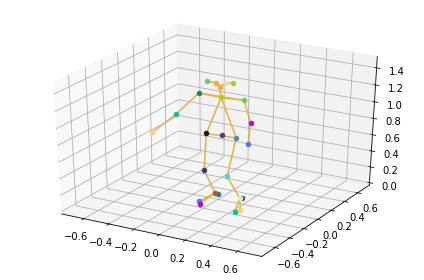

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

def draw_3d_skeleton(ax, skeletons):
  for bone in BODY_BONES_POSE_25:
    kp_1 = skeletons[bone[0].value]
    kp_2 = skeletons[bone[1].value]
    if(kp_1[3] > 0.5 and kp_2[3] > 0.5):
      ax.plot([-kp_1[0], -kp_2[0]], [-kp_1[1], -kp_2[1]], [-kp_1[2], -kp_2[2]], color=plt_clr)

    #for part in range(len(BODY_PARTS_POSE_25)-1):
    #  kp = skeletons[part]
    #  ax.scatter(kp[0], kp[1], kp[2], color=plt_clr)

  for part in BODY_PARTS_POSE_25:
    if part.value < 25:
      kp = skeletons[part.value]
      if kp[3] > 0.5:
        circle_color = generate_color_id_u(part.value)
        plt_circle_clr = [circle_color[0]/255, circle_color[1]/255, circle_color[2]/255]
        ax.scatter(-kp[0], -kp[1], -kp[2], color=plt_circle_clr)

fig = plt.figure()
ax = plt.axes(projection='3d')
clr = generate_color_id_u(0)
plt_clr = [clr[0]/255, clr[1]/255, clr[2]/255]
plt.tight_layout()

plt.xlim(-0.75, 0.75)
plt.ylim(-0.75, 0.75)
ax.set_zlim(0, 1.5)

draw_3d_skeleton(ax, out)